In [5]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import csv
import openpyxl
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble

plt.rcParams['figure.figsize'] = (10.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


#### This data has some weird encoding issues... need a helper function

In [6]:
def xuni(s):
    if not s:
        return u''
    elif type(s) == unicode:
        return s.encode('utf-8')
    elif type(s) == str:
        return unicode(s, 'utf-8')
    else: return ''
    

### Convert xlsx to csv, dealing with encoding issues
Notes: 
* made a file with just three columns, date, reviews and 2_or_more_ill
* also dropped '3' and '9' labels because they can't help (and there's only like 5 total)


In [7]:
#Original regression values + annotations
wb = openpyxl.load_workbook('mult_data.xlsx')
sh = wb.active
with open('mult_data.csv', 'wb') as f:
    c = csv.writer(f)
    for r in sh.rows:
        c.writerow([cell.value for cell in r])

/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/openpyxl/reader/worksheet.py:320: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [8]:
##Annotated Reviews
wb = openpyxl.load_workbook('yelp_mult_data.xlsx')
sh = wb.active
with open('yelp_mult_data.csv', 'wb') as f:
    c = csv.writer(f)
    for r in sh.rows:
        c.writerow([xuni(cell.value) for cell in r])

### Now let's write out the data we care about (but only the first 1/3) 

In [9]:
num_records = len([i for i,_ in enumerate(csv.reader(open('yelp_mult_data.csv', 'rU'), dialect='excel'))])
stop = num_records/3
print "Keeping the first %i records" % stop
with open('yelp_mult_data.csv', 'rU') as f:
    reader = csv.reader(f, dialect='excel')
    with open('yelp_mult_data_small.csv', 'w') as w:
        writer = csv.writer(w)
        seenlen = []
        for l, row in enumerate(reader):
            # get indices we care about
#             print l
            if len(row) not in seenlen:
                print len(row), ':: ', row
                print
                seenlen.append(len(row))
            if l == 0:
                rev_i = row.index('Review')
                mult_i = row.index('2_Or_More_Ill')
                writer.writerow(['data', 'label'])
            elif row[rev_i] and row[mult_i] and row[mult_i] != '3' and row[mult_i] != '9': # skip blank rows
                if row[mult_i] == '2':
                    writer.writerow([row[rev_i], '0'])
                elif row[mult_i] == '1':
                    writer.writerow([row[rev_i], '1'])
                else:continue
            else: continue
            if l >= stop: break

Keeping the first 2966 records
3 ::  ['Date_Review', 'Review', '2_Or_More_Ill']



#### And check that it looks good

In [10]:
with open('yelp_mult_data_small.csv', 'rU') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        if i <=10: 
            print "%i:: %r" % (i, row)
            print

0:: ['data', 'label']

1:: ['My friends and I ordered 3 burgers and a pitcher of sangria. Everything tasted good. Later on in the day we all got a stomach ache then 1 by 1 we all had to use the restroom several times before the days end. I love this place, but something there made us sick. \n\nIf I go back, I&#39;m going to stick with bottled beer.', '1']

2:: ['Went here yesterday with a friend.  We both got food poisoning, most likely from the cajun chicken. Resulted in a pretty rough night last night and for my friend, a rough day today (will spare the details, but you can imagine).\n\nWould recommend steering clear unless you&#39;re looking to ruin about 24 hours of your life.\n\nGood happy hour special though after the last 24 hours I&#39;d stick to bottled beverages, trust factor on anything prepared there is low.\n\nAs an aside, during a previous trip, we were required to order at our tables rather than the counter, this caused the length of our visit to nearly double since they

## Cool.  So let's start messing with classification

### Define our (very basic) classifier pipeline

In [11]:
from sklearn.pipeline import Pipeline

# Feature Extractors
from sklearn.feature_extraction.text import CountVectorizer
f1 = CountVectorizer(
        input=u'content', 
        encoding=u'utf-8', 
        decode_error=u'strict', 
        strip_accents=None, 
        lowercase=True, 
        preprocessor=None, 
        tokenizer=None, 
        stop_words=None, 
        #token_pattern=u'(?u)\\b\w\w+\b', # one alphanumeric is a token
        ngram_range=(1, 1), 
        analyzer=u'word', 
        max_df=1.0, 
        min_df=1, 
        max_features=None, 
        vocabulary=None, 
        binary=False, 
        #dtype=type 'numpy.int64'>
        )

from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
rf = ensemble.RandomForestRegressor(
    oob_score = True,
    random_state =0
)
from sklearn import linear_model
log = linear_model.LogisticRegression()
#Pipeline
pipeline = Pipeline([
        ('count', f1),
        ('tfidf', tfidf),
        ('log', log)
    ])

In general, we are most interested in a classifier that positively labels as many true positives as possible. 
This is equivalent to maximizing the Positive label recall, so define that scoring function

In [12]:
from sklearn.metrics import make_scorer

from sklearn.metrics import roc_auc_score
def my_roc_auc(estimator, ground_truth, predictions) :
    ground_truth = np.array(ground_truth)
    print ground_truth
    predictions = np.array(predictions)
    print predictions
    return roc_auc_score(ground_truth, predictions)

def ms_error(ground_truth, predictions):
    ## Calculate rmse for reviews that have real label of 'yes'
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    real_yes = ground_truth[np.where(ground_truth == 1)]
    pred_for_yes = predictions[np.where(ground_truth == 1)] ## predicted value for 'yes' reviews'
    y_error = metrics.mean_squared_error(real_yes, pred_for_yes) **.5 ## rmse for 'yes' reviews
    
    ## Calculate rmse for reviews that have real label of 'yes'
    real_no = ground_truth[np.where(ground_truth == 0)]
    pred_for_no = predictions[np.where(ground_truth == 0)] ## predicted value for 'no' reviews
    n_error = metrics.mean_squared_error(real_no, pred_for_no) **.5 ## rmse for 'no' reviews
    
    print y_error
    print n_error
    ## F2 score, weighted to favor y_error
    ##error = ( (2**2 + 1) * y_error * n_error) / (y_error + (2**2) * n_error) 
    error = (2.0/3.0) * y_error + (1.0/3.0) * n_error
    return error
    #return metrics.mean_squared_error(ground_truth, predictions)

    
def pos_recall(ground_truth, predictions, pos_label='yes'):
    ground_truth = np.array(ground_truth)
    predictions = np.array(predictions)
    true_preds = predictions[np.where(ground_truth == pos_label)]
    true_pos = ground_truth[np.where(ground_truth == pos_label)]
    return float(len(true_preds[np.where(true_preds == true_pos)]))/len(true_pos)

ms_error_scorer = make_scorer(ms_error, greater_is_better=True)
pos_recall_scorer = make_scorer(pos_recall, greater_is_better=True)
my_roc_auc_scorer = make_scorer(my_roc_auc, greater_is_better=True)

### Here are two functions to generate plots

In [13]:
def plot_confusion_matrix(cm, label_names, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots()
    
    min_val, max_val, diff = 0., len(cm.astype('float')[:,0]), 1.

    #text portion
    x, y = np.meshgrid(range(cm.shape[0]), range(cm.shape[1]))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = "%i = %0.2f" % (cm.astype('int')[x_val, y_val], cm_normalized[x_val, y_val])
        ax.text(y_val, x_val, c, va='center', ha='center')

    #set tick marks for grid
    ax.set_xticks(np.arange(min_val-diff/2, max_val-diff/2))
    ax.set_yticks(np.arange(min_val-diff/2, max_val-diff/2))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(min_val-diff/2, max_val-diff/2)
    ax.set_ylim(min_val-diff/2, max_val-diff/2)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks, label_names)#, rotation=45)
    plt.yticks(tick_marks, label_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_histo(values, nbins=50, xlabel="Value", ylabel="Frequency", title="Histogram"):
    plt.hist(values, nbins, color='cadetblue')
    plt.title(title)     
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

### These three functions split up the basic initial steps of an experiment

In [14]:
from sklearn import preprocessing
def load_data(csvfile, delim):
    data = { 'x':[], 'y':[]}
    with open(csvfile, 'r') as f:
        reader = csv.reader(f, delimiter=delim)
        print "HEADERS: ", reader.next()
        for row in reader:
            data['x'].append(row[0])
#             print row[1]
            data['y'].append(row[1])
    data['x'] = np.array(data['x']) #.astype(np.float) #astype only for loading old data
    data['y'] = np.array(data['y'])
    
    for i in range (len(data['y'])):
        if data['y'][i] == '0':
            data['y'][i] = 0.0
        else:
            data['y'][i] = 1.0
            
    lb = preprocessing.LabelEncoder()
    data['y'] = lb.fit_transform(data['y'])
    
    n = len(data['y'])
    labels = sorted(list(set(data['y'])))
    print "Labels: ", labels
    pos = [d for d in data['y'] if d==1] 
    print "Positive Examples: %i = %0.2f" % (len(pos), len(pos)/float(n))
    neg = [d for d in data['y'] if d==0] 
    print "Negative Examples: %i = %0.2f" % (len(neg), len(neg)/float(n))
    return data, labels

def split_dev_test(data, test_size=.2):
    train_data = {}
    test_data = {}
    for train, test in cross_validation.StratifiedShuffleSplit(data['y'], n_iter=1, test_size=test_size, random_state=0):
        train_data['x'] = data['x'][train]
        train_data['y'] = data['y'][train]
        test_data['x'] = data['x'][test]
        test_data['y'] = data['y'][test]
        
    print "Training/Dev data shape: ", train_data['x'].shape, train_data['y'].shape
    print "Test data shape: ",test_data['x'].shape, test_data['y'].shape
    return train_data, test_data

from sklearn.metrics import roc_auc_score
def parameter_search(data, pipeline, paramgrid, n_folds=3, gscv_kwargs=None):
    print "SEARCHING PARAMETER SPACE:"
    folds = cross_validation.StratifiedKFold(data['x'], n_folds=n_folds, random_state=0,shuffle=True)
    if not gscv_kwargs:
        gscv_kwargs = {
             'scoring':ms_error, 
             'fit_params':None, 
             'n_jobs':-1, 
             'iid':True, 
             'refit':True, 
             'cv':folds, 
             'verbose':2, 
    #                  pre_dispatch=None, 
             'error_score':'raise'
        }
    gscv = grid_search.GridSearchCV(pipeline, paramgrid, **gscv_kwargs)
    gscv.fit(data['x'], data['y'])
    return gscv



### Load the data from the file we created above

In [15]:
csvfile = 'mult_data.csv'
delim=','
old_data, old_labels = load_data(csvfile, delim)
#print np.array(old_pred).shape, np.array(old_labels).shape
print metrics.roc_auc_score(old_data['y'], old_data['x']) #true values, then scores

HEADERS:  ['Multiple', '2OrMoreAsBool (Health Dept. Val)']
Labels:  [0, 1]
Positive Examples: 779 = 0.12
Negative Examples: 5497 = 0.88
0.650942993062


In [15]:
csvfile = 'yelp_mult_data_small.csv'
delim=','
data, labels = load_data(csvfile, delim)

HEADERS:  ['data', 'label']
Labels:  [0, 1]
Positive Examples: 177 = 0.13
Negative Examples: 1215 = 0.87


### Now split the data into a training/dev set and a final test set
(It is poor practice to tune parameters and evaluate performance on the same 'test' dataset.

So usually people actually split the data into 3 sets: train/development/test

In [16]:
train_data, test_data = split_dev_test(data)

Training/Dev data shape:  (1113,) (1113,)
Test data shape:  (279,) (279,)


In [28]:
for i in range (0, 1113):
    if (train_data['y'][i] != 0) & (train_data['y'][i] != 1) :
        print train_data['y'][i]
print "done"

done


### This is an example of a parameter grid to exhaustively search. 

You can customize how the search is done by defining your own dictionary with the settings and passing that to parameter_search


In [40]:
param_grid = {
    'count__ngram_range': [(1,2)],
    'count__min_df': [1, 10],
    'count__max_df' : [.8, 1.0],
    'count__stop_words': [None],
    'tfidf__use_idf' : [True, False],
    'tfidf__norm': [('l1'), None],
    'log__C': [ 0.01, .1, 1, 10, 50, 100, 1000],
    #'reg__n_estimators': [ 10, 20, 30, 35, 40, 50],
    #'reg__max_features':['auto'],
    #'reg__max_depth': [50, 75, 100]
}
tuning_results = parameter_search(train_data, pipeline, param_grid)

SEARCHING PARAMETER SPACE:
Fitting 3 folds for each of 112 candidates, totalling 336 fits
[CV] count__stop_words=None, count__max_df=0.8, tfidf__norm=l1, count__min_df=1, log__C=0.01, tfidf__use_idf=True, count__ngram_range=(1, 2) 
[CV] count__stop_words=None, count__max_df=0.8, tfidf__norm=l1, count__min_df=1, log__C=0.01, tfidf__use_idf=True, count__ngram_range=(1, 2) 
[CV] count__stop_words=None, count__max_df=0.8, tfidf__norm=l1, count__min_df=1, log__C=0.01, tfidf__use_idf=True, count__ngram_range=(1, 2) 
[CV] count__stop_words=None, count__max_df=0.8, tfidf__norm=l1, count__min_df=1, log__C=0.01, tfidf__use_idf=False, count__ngram_range=(1, 2) 
[CV] count__stop_words=None, count__max_df=0.8, tfidf__norm=l1, count__min_df=1, log__C=0.01, tfidf__use_idf=False, count__ngram_range=(1, 2) 
[CV] count__stop_words=None, count__max_df=0.8, tfidf__norm=l1, count__min_df=1, log__C=0.01, tfidf__use_idf=False, count__ngram_range=(1, 2) 
[CV] count__stop_words=None, count__max_df=0.8, tfidf__

JoblibTypeError: JoblibTypeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    157     pkg_name = mod_name.rpartition('.')[0]
    158     main_globals = sys.modules["__main__"].__dict__
    159     if alter_argv:
    160         sys.argv[0] = fname
    161     return _run_code(code, main_globals, None,
--> 162                      "__main__", fname, loader, pkg_name)
        fname = '/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    163 
    164 def run_module(mod_name, init_globals=None,
    165                run_name=None, alter_sys=False):
    166     """Execute a module's code without importing it

...........................................................................
/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x10bb2df30, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/annal...python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x10bb2df30, file "/Use...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/Users/annal...python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    587         
    588         If a global instance already exists, this reinitializes and starts it
    589         """
    590         app = cls.instance(**kwargs)
    591         app.initialize(argv)
--> 592         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    593 
    594 #-----------------------------------------------------------------------------
    595 # utility functions, for convenience
    596 #-----------------------------------------------------------------------------

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    384     def start(self):
    385         if self.poller is not None:
    386             self.poller.start()
    387         self.kernel.start()
    388         try:
--> 389             ioloop.IOLoop.instance().start()
    390         except KeyboardInterrupt:
    391             pass
    392 
    393 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    146             PollIOLoop.configure(ZMQIOLoop)
    147         return PollIOLoop.instance()
    148     
    149     def start(self):
    150         try:
--> 151             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    152         except ZMQError as e:
    153             if e.errno == ETERM:
    154                 # quietly return on ETERM
    155                 pass

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    861                 self._events.update(event_pairs)
    862                 while self._events:
    863                     fd, events = self._events.popitem()
    864                     try:
    865                         fd_obj, handler_func = self._handlers[fd]
--> 866                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    867                     except (OSError, IOError) as e:
    868                         if errno_from_exception(e) == errno.EPIPE:
    869                             # Happens when the client closes the connection
    870                             pass

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    428             # dispatch events:
    429             if events & IOLoop.ERROR:
    430                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    431                 return
    432             if events & IOLoop.READ:
--> 433                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    434                 if not self.socket:
    435                     return
    436             if events & IOLoop.WRITE:
    437                 self._handle_send()

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    460                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    461         else:
    462             if self._recv_callback:
    463                 callback = self._recv_callback
    464                 # self._recv_callback = None
--> 465                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    466                 
    467         # self.update_state()
    468         
    469 

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    402         close our socket."""
    403         try:
    404             # Use a NullContext to ensure that all StackContexts are run
    405             # inside our blanket exception handler rather than outside.
    406             with stack_context.NullContext():
--> 407                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    408         except:
    409             gen_log.error("Uncaught exception, closing connection.",
    410                           exc_info=True)
    411             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    247         if self.control_stream:
    248             self.control_stream.on_recv(self.dispatch_control, copy=False)
    249 
    250         def make_dispatcher(stream):
    251             def dispatcher(msg):
--> 252                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    253             return dispatcher
    254 
    255         for s in self.shell_streams:
    256             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"param_grid = {\n    'count__ngram_range': [(1,...rameter_search(train_data, pipeline, param_grid)", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'msg_id': u'81D558CD9B5F40FD9F295F1F554D214E', u'msg_type': u'execute_request', u'session': u'8448D4D5706A48B788F747A7968BD255', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'81D558CD9B5F40FD9F295F1F554D214E', 'msg_type': u'execute_request', 'parent_header': {}})
    208         else:
    209             # ensure default_int_handler during handler call
    210             sig = signal(SIGINT, default_int_handler)
    211             self.log.debug("%s: %s", msg_type, msg)
    212             try:
--> 213                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['8448D4D5706A48B788F747A7968BD255']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u"param_grid = {\n    'count__ngram_range': [(1,...rameter_search(train_data, pipeline, param_grid)", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'msg_id': u'81D558CD9B5F40FD9F295F1F554D214E', u'msg_type': u'execute_request', u'session': u'8448D4D5706A48B788F747A7968BD255', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'81D558CD9B5F40FD9F295F1F554D214E', 'msg_type': u'execute_request', 'parent_header': {}}
    214             except Exception:
    215                 self.log.error("Exception in message handler:", exc_info=True)
    216             finally:
    217                 signal(SIGINT, sig)

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['8448D4D5706A48B788F747A7968BD255'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u"param_grid = {\n    'count__ngram_range': [(1,...rameter_search(train_data, pipeline, param_grid)", u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'msg_id': u'81D558CD9B5F40FD9F295F1F554D214E', u'msg_type': u'execute_request', u'session': u'8448D4D5706A48B788F747A7968BD255', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'81D558CD9B5F40FD9F295F1F554D214E', 'msg_type': u'execute_request', 'parent_header': {}})
    357         if not silent:
    358             self.execution_count += 1
    359             self._publish_execute_input(code, parent, self.execution_count)
    360 
    361         reply_content = self.do_execute(code, silent, store_history,
--> 362                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    363 
    364         # Flush output before sending the reply.
    365         sys.stdout.flush()
    366         sys.stderr.flush()

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u"param_grid = {\n    'count__ngram_range': [(1,...rameter_search(train_data, pipeline, param_grid)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    170 
    171         reply_content = {}
    172         # FIXME: the shell calls the exception handler itself.
    173         shell._reply_content = None
    174         try:
--> 175             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u"param_grid = {\n    'count__ngram_range': [(1,...rameter_search(train_data, pipeline, param_grid)"
        store_history = True
        silent = False
    176         except:
    177             status = u'error'
    178             # FIXME: this code right now isn't being used yet by default,
    179             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u"param_grid = {\n    'count__ngram_range': [(1,...rameter_search(train_data, pipeline, param_grid)", store_history=True, silent=False, shell_futures=True)
   2897                 self.displayhook.exec_result = result
   2898 
   2899                 # Execute the user code
   2900                 interactivity = "none" if silent else self.ast_node_interactivity
   2901                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2902                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2903 
   2904                 # Reset this so later displayed values do not modify the
   2905                 # ExecutionResult
   2906                 self.displayhook.exec_result = None

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>], cell_name='<ipython-input-40-4b308c7d2dab>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3001 
   3002         try:
   3003             for i, node in enumerate(to_run_exec):
   3004                 mod = ast.Module([node])
   3005                 code = compiler(mod, cell_name, "exec")
-> 3006                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x1116b36b0, file "<ipython-input-40-4b308c7d2dab>", line 13>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   3007                     return True
   3008 
   3009             for i, node in enumerate(to_run_interactive):
   3010                 mod = ast.Interactive([node])

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x1116b36b0, file "<ipython-input-40-4b308c7d2dab>", line 13>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3061         outflag = 1  # happens in more places, so it's easier as default
   3062         try:
   3063             try:
   3064                 self.hooks.pre_run_code_hook()
   3065                 #rprint('Running code', repr(code_obj)) # dbg
-> 3066                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x1116b36b0, file "<ipython-input-40-4b308c7d2dab>", line 13>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, 'Circle': <class 'matplotlib.patches.Circle'>, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, 'Circle': <class 'matplotlib.patches.Circle'>, ...}
   3067             finally:
   3068                 # Reset our crash handler in place
   3069                 sys.excepthook = old_excepthook
   3070         except SystemExit as e:

...........................................................................
/Users/annalawson/Documents/health_py/ml_example/<ipython-input-40-4b308c7d2dab> in <module>()
      8     'log__C': [ 0.01, .1, 1, 10, 50, 100, 1000],
      9     #'reg__n_estimators': [ 10, 20, 30, 35, 40, 50],
     10     #'reg__max_features':['auto'],
     11     #'reg__max_depth': [50, 75, 100]
     12 }
---> 13 tuning_results = parameter_search(train_data, pipeline, param_grid)
     14 
     15 
     16 
     17 

...........................................................................
/Users/annalawson/Documents/health_py/ml_example/<ipython-input-39-1b65683b676e> in parameter_search(data={'x': array([ 'I ordered Rosa Mexicano for delivery a ...ison only not as clean."], 
      dtype='|S4952'), 'y': array([0, 1, 0, ..., 0, 0, 0])}, pipeline=Pipeline(steps=[('count', CountVectorizer(analyz...0.0001,
          verbose=0, warm_start=False))]), paramgrid={'count__max_df': [0.8, 1.0], 'count__min_df': [1, 10], 'count__ngram_range': [(1, 2)], 'count__stop_words': [None], 'log__C': [0.01, 0.1, 1, 10, 50, 100, 1000], 'tfidf__norm': ['l1', None], 'tfidf__use_idf': [True, False]}, n_folds=3, gscv_kwargs={'cv': sklearn.cross_validation.StratifiedKFold(labels=...lean."], n_folds=3, shuffle=True, random_state=0), 'error_score': 'raise', 'fit_params': None, 'iid': True, 'n_jobs': -1, 'refit': True, 'scoring': <function ms_error>, 'verbose': 2})
     57              'verbose':2, 
     58     #                  pre_dispatch=None, 
     59              'error_score':'raise'
     60         }
     61     gscv = grid_search.GridSearchCV(pipeline, paramgrid, **gscv_kwargs)
---> 62     gscv.fit(data['x'], data['y'])
     63     return gscv
     64 
     65 
     66 

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/sklearn/grid_search.py in fit(self=GridSearchCV(cv=sklearn.cross_validation.Stratif...ng=<function ms_error at 0x111a079b0>, verbose=2), X=array([ 'I ordered Rosa Mexicano for delivery a ...ison only not as clean."], 
      dtype='|S4952'), y=array([0, 1, 0, ..., 0, 0, 0]))
    799         y : array-like, shape = [n_samples] or [n_samples, n_output], optional
    800             Target relative to X for classification or regression;
    801             None for unsupervised learning.
    802 
    803         """
--> 804         return self._fit(X, y, ParameterGrid(self.param_grid))
        self._fit = <bound method GridSearchCV._fit of GridSearchCV(...g=<function ms_error at 0x111a079b0>, verbose=2)>
        X = array([ 'I ordered Rosa Mexicano for delivery a ...ison only not as clean."], 
      dtype='|S4952')
        y = array([0, 1, 0, ..., 0, 0, 0])
        self.param_grid = {'count__max_df': [0.8, 1.0], 'count__min_df': [1, 10], 'count__ngram_range': [(1, 2)], 'count__stop_words': [None], 'log__C': [0.01, 0.1, 1, 10, 50, 100, 1000], 'tfidf__norm': ['l1', None], 'tfidf__use_idf': [True, False]}
    805 
    806 
    807 class RandomizedSearchCV(BaseSearchCV):
    808     """Randomized search on hyper parameters.

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/sklearn/grid_search.py in _fit(self=GridSearchCV(cv=sklearn.cross_validation.Stratif...ng=<function ms_error at 0x111a079b0>, verbose=2), X=array([ 'I ordered Rosa Mexicano for delivery a ...ison only not as clean."], 
      dtype='|S4952'), y=array([0, 1, 0, ..., 0, 0, 0]), parameter_iterable=<sklearn.grid_search.ParameterGrid object>)
    548         )(
    549             delayed(_fit_and_score)(clone(base_estimator), X, y, self.scorer_,
    550                                     train, test, self.verbose, parameters,
    551                                     self.fit_params, return_parameters=True,
    552                                     error_score=self.error_score)
--> 553                 for parameters in parameter_iterable
        parameters = undefined
        parameter_iterable = <sklearn.grid_search.ParameterGrid object>
    554                 for train, test in cv)
    555 
    556         # Out is a list of triplet: score, estimator, n_test_samples
    557         n_fits = len(out)

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    807             if pre_dispatch == "all" or n_jobs == 1:
    808                 # The iterable was consumed all at once by the above for loop.
    809                 # No need to wait for async callbacks to trigger to
    810                 # consumption.
    811                 self._iterating = False
--> 812             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    813             # Make sure that we get a last message telling us we are done
    814             elapsed_time = time.time() - self._start_time
    815             self._print('Done %3i out of %3i | elapsed: %s finished',
    816                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
TypeError                                          Tue Dec  1 20:34:00 2015
PID: 17416   Python 2.7.5: /Users/annalawson/.virtualenvs/health/bin/python
...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.pyc in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/sklearn/cross_validation.pyc in _fit_and_score(estimator=Pipeline(steps=[('count', CountVectorizer(analyz...0.0001,
          verbose=0, warm_start=False))]), X=memmap([ 'I ordered Rosa Mexicano for delivery a...ison only not as clean."], 
      dtype='|S4952'), y=array([0, 1, 0, ..., 0, 0, 0]), scorer=<function ms_error>, train=array([   0,    2,    3,    4,    5,    7,   11,...1103, 1104, 1105,
       1108, 1109, 1110, 1112]), test=array([   1,    6,    8,    9,   10,   18,   19,... 1088, 1091, 1094, 1096, 1100, 1106, 1107, 1111]), verbose=2, parameters={'count__max_df': 0.8, 'count__min_df': 1, 'count__ngram_range': (1, 2), 'count__stop_words': None, 'log__C': 0.01, 'tfidf__norm': 'l1', 'tfidf__use_idf': True}, fit_params={}, return_train_score=False, return_parameters=True, error_score='raise')
   1545                              " numeric value. (Hint: if using 'raise', please"
   1546                              " make sure that it has been spelled correctly.)"
   1547                              )
   1548 
   1549     else:
-> 1550         test_score = _score(estimator, X_test, y_test, scorer)
   1551         if return_train_score:
   1552             train_score = _score(estimator, X_train, y_train, scorer)
   1553 
   1554     scoring_time = time.time() - start_time

...........................................................................
/Users/annalawson/.virtualenvs/health/lib/python2.7/site-packages/sklearn/cross_validation.pyc in _score(estimator=Pipeline(steps=[('count', CountVectorizer(analyz...0.0001,
          verbose=0, warm_start=False))]), X_test=memmap([ "So it has come to my attention that th...ore Fiorentinos for me."], 
      dtype='|S4952'), y_test=array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0]), scorer=<function ms_error>)
   1601 def _score(estimator, X_test, y_test, scorer):
   1602     """Compute the score of an estimator on a given test set."""
   1603     if y_test is None:
   1604         score = scorer(estimator, X_test)
   1605     else:
-> 1606         score = scorer(estimator, X_test, y_test)
   1607     if not isinstance(score, numbers.Number):
   1608         raise ValueError("scoring must return a number, got %s (%s) instead."
   1609                          % (str(score), type(score)))
   1610     return score

TypeError: ms_error() takes exactly 2 arguments (3 given)
___________________________________________________________________________

With these results, we can see what the general distribution of classifcation results looked like

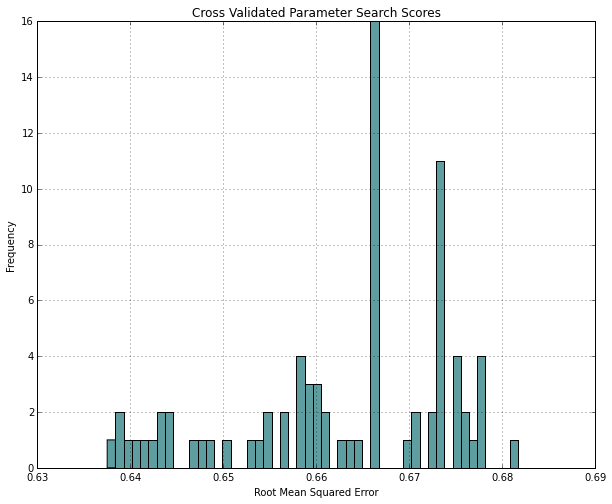

In [22]:
scores = [r.mean_validation_score for r in tuning_results.grid_scores_]        
plot_histo(scores,
           title="Cross Validated Parameter Search Scores",
           xlabel="Root Mean Squared Error")



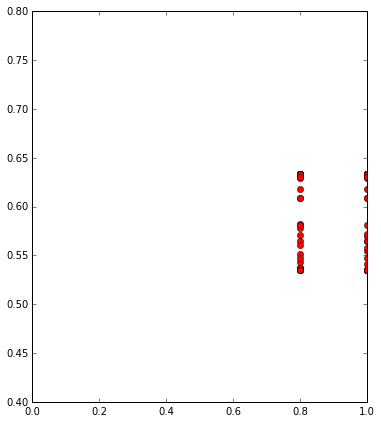

In [64]:
##max_df
num_trees = [r.parameters['count__max_df'] for r in tuning_results.grid_scores_]
##for i in range(len(num_trees)):
  ##  if num_trees[i] == 'linear':      
    ##    num_trees[i] = 0
    ##else:
      #  num_trees[i] = 1
plt.plot(num_trees, scores, 'ro')
plt.axis([0, 1, .4, .8])
plt.show()

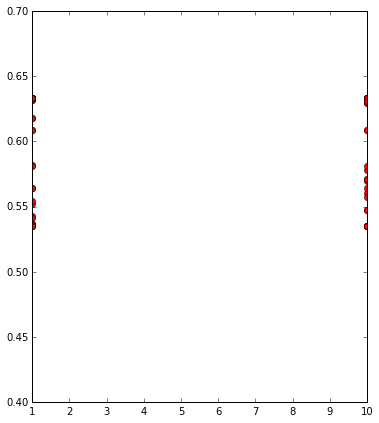

In [71]:
##min_df
num_trees = [r.parameters['count__min_df'] for r in tuning_results.grid_scores_]
##for i in range(len(num_trees)):
  ##  if num_trees[i] == 'linear':      
    ##    num_trees[i] = 0
    ##else:
      #  num_trees[i] = 1
plt.plot(num_trees, scores, 'ro')
plt.axis([1, 10, .4, .7])
plt.show()

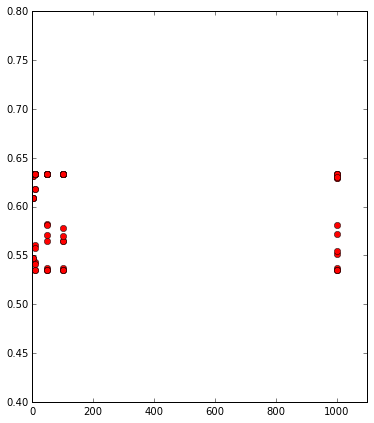

In [77]:
##C
num_trees = [r.parameters['svr__C'] for r in tuning_results.grid_scores_]
##for i in range(len(num_trees)):
  ##  if num_trees[i] == 'linear':      
    ##    num_trees[i] = 0
    ##else:
      #  num_trees[i] = 1
plt.plot(num_trees, scores, 'ro')
plt.axis([0, 1100, .4, .8])
plt.show()

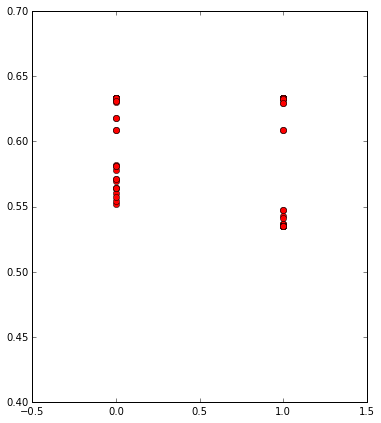

In [74]:
##Use_IDF
num_trees = [r.parameters['tfidf__use_idf'] for r in tuning_results.grid_scores_]
for i in range(len(num_trees)):
    if num_trees[i] == False:      
        num_trees[i] = 0
    else:
        num_trees[i] = 1
plt.plot(num_trees, scores, 'ro')
plt.axis([-.5, 1.5, .4, .7])
plt.show()

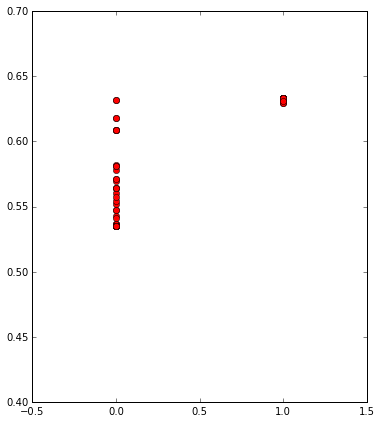

In [75]:
##Norm
num_trees = [r.parameters['tfidf__norm'] for r in tuning_results.grid_scores_]
for i in range(len(num_trees)):
    if num_trees[i] == None:      
        num_trees[i] = 0
    else:
        num_trees[i] = 1
plt.plot(num_trees, scores, 'ro')
plt.axis([-.5, 1.5, .4, .7])
plt.show()

In [76]:
plt.rcParams['figure.figsize'] = (6,7)
topk = 3
ranked_results = sorted(tuning_results.grid_scores_, key=lambda x:x.mean_validation_score, reverse=False)
best_score = 1 ## 1 is highest
best_index = 0
best_params = None
for i, result in enumerate(ranked_results[:topk]):
    params = result.parameters
    pipeline.set_params(**params).fit(train_data['x'], train_data['y'])
    train_preds = pipeline.predict(train_data['x'])
    test_preds = pipeline.predict(test_data['x'])
    print "GRID SEARCH SCORE: %0.4f" % result.mean_validation_score
    print "TRAIN SCORE: %0.4f" % ms_error(train_data['y'], train_preds)
    test_score = ms_error(test_data['y'], test_preds)
    print "TEST SCORE: %0.4f" % test_score
    print "PARAMS"
    print params
    if test_score < best_score: 
        best_score=test_score
        best_index = i
        best_params = params
        
for i, result in enumerate(ranked_results[len(ranked_results) - 3:]):
    params = result.parameters
    pipeline.set_params(**params).fit(train_data['x'], train_data['y'])
    train_preds = pipeline.predict(train_data['x'])
    test_preds = pipeline.predict(test_data['x'])
    print "GRID SEARCH SCORE: %0.4f" % result.mean_validation_score
    print "TRAIN SCORE: %0.4f" % ms_error(train_data['y'], train_preds)
    test_score = ms_error(test_data['y'], test_preds)
    print "TEST SCORE: %0.4f" % test_score
    print "PARAMS"
    print params

GRID SEARCH SCORE: 0.5349
0.0999996809404
0.089511528797
TRAIN SCORE: 0.0965
0.639990738919
0.214621739292
TEST SCORE: 0.4982
PARAMS
{'count__stop_words': None, 'count__max_df': 1.0, 'tfidf__norm': None, 'count__min_df': 10, 'svr__kernel': 'rbf', 'svr__C': 50, 'tfidf__use_idf': True, 'count__ngram_range': (1, 2)}
GRID SEARCH SCORE: 0.5349
0.0999996809404
0.089511528797
TRAIN SCORE: 0.0965
0.639990738919
0.214621739292
TEST SCORE: 0.4982
PARAMS
{'count__stop_words': None, 'count__max_df': 1.0, 'tfidf__norm': None, 'count__min_df': 10, 'svr__kernel': 'rbf', 'svr__C': 100, 'tfidf__use_idf': True, 'count__ngram_range': (1, 2)}
GRID SEARCH SCORE: 0.5349
0.0999996809404
0.089511528797
TRAIN SCORE: 0.0965
0.639990738919
0.214621739292
TEST SCORE: 0.4982
PARAMS
{'count__stop_words': None, 'count__max_df': 1.0, 'tfidf__norm': None, 'count__min_df': 10, 'svr__kernel': 'rbf', 'svr__C': 1000, 'tfidf__use_idf': True, 'count__ngram_range': (1, 2)}
GRID SEARCH SCORE: 0.6335
0.901633672984
0.097921321

### Given the best test score, we can see what those parameters were, and save the model to a file if we want to use it later

In [ ]:
best = ranked_results[best_index]
print "BEST TEST POSITIVE RECALL: %0.4f" % best_score
print "BEST MODEL PARAMS: %r" % best_params
model = pipeline.set_params(**best_params).fit(data['x'], data['y'])

In [ ]:
from sklearn.externals import joblib
joblib.dump(model, 'multiple_rf.pkl') 

Don't worry about why that has multiple files, just know to load the model later all of those files must be in the directory.

But just refer to it with the original filename

In [ ]:
multiple = joblib.load('best_multiple_clf.pkl') 
preds = multiple.predict(data['x'])

## This should give you a good setup to continue improving the models!

Almost all of the info you need for using sci-kitlearn is in the online documentation (as well as a ton of practical tips and examples for how to do good ML in general).

When it comes to plotting stuff, generally I just google "matplotlib _what kind of plot I want_" and someone has usually sdone like 95% of the work already :)

Feel free to send me any questions you have and enjoy your new life in the [wonderful world of python](https://xkcd.com/353/)